# ORIE 5160 Project

Dihong Luo (dl2247), Hanyong Lin (hl2523), Ken Qin (kq63)

In [ ]:
!pip3 install -q -U evaluate
import collections
import json
import os
import pathlib
import random

import datasets
import evaluate
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import peft
import torch
import torch.nn.functional as F
import transformers
from sklearn import metrics

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
PATH = "/content/drive/MyDrive/ORIE 5160 Project"

## set hyper-parameters

In [ ]:
# set hyper parameters

seed = 42
model_name = "distilbert-base-uncased"  # bert-base-uncased
test_prop = 0.2
valid_prop = 0.15
tok_max_length = 64
data_version = "Sentences_50Agree"
early_stopping_patience = 4

# max_length_quantile=0.95 # quantile used for tokenizing max length


# param_grid = {
#     "distilbert-base-uncased": {
#         "learning_rate": [1e-5, 2e-5, 5e-5],
#         "num_train_epochs": [5, 10],
#         "per_device_train_batch_size": [16, 32],
#         "weight_decay": [0.01],
#         "warmup_ratio": [0.1],
#         "lr_scheduler_type": ["linear"],
#     }
# }

In [ ]:
# fix random seeds

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms = True
os.environ["PYTHONHASHSEED"] = str(seed)  # fix hash randomness

In [ ]:
# auto choose training device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cuda


## data preparation

In [ ]:
df = pd.read_csv(
    f"{PATH}/data/{data_version}.txt",
    sep="@",
    names=["sentence", "label"],
    engine="python",
    encoding="latin1",
)
df["sentence"] = df["sentence"].str.strip()
df["label"] = df["label"].str.strip()
df.head()

,sentence,label
0,"According to Gran , the company has no plans t...",neutral
1,Technopolis plans to develop in stages an area...,neutral
2,The international electronic industry company ...,negative
3,With the new production plant the company woul...,positive
4,According to the company 's updated strategy f...,positive


In [ ]:
label_map = {"negative": 0, "neutral": 1, "positive": 2}
df["label"] = df["label"].map(label_map)
df.head()

,sentence,label
0,"According to Gran , the company has no plans t...",1
1,Technopolis plans to develop in stages an area...,1
2,The international electronic industry company ...,0
3,With the new production plant the company woul...,2
4,According to the company 's updated strategy f...,2


In [ ]:
dataset = datasets.Dataset.from_pandas(df)
dataset

Dataset({
    features: ['sentence', 'label'],
    num_rows: 4846
})

In [ ]:
tmp_data = dataset.train_test_split(test_size=test_prop, seed=seed)

train_and_validation_set = tmp_data["train"]
test_set = tmp_data["test"]

tmp_data_2 = train_and_validation_set.train_test_split(test_size=valid_prop, seed=seed)

train_set, validation_set = tmp_data_2["train"], tmp_data_2["test"]

print(f"training set size: {len(train_set)}")
print(f"validation set size: {len(validation_set)}")
print(f"testing set size: {len(test_set)}")

training set size: 3294
validation set size: 582
testing set size: 970


## tokenization

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/3294 [00:00<?, ? examples/s]

training set number of tokens 0.95 quantile: 56.0


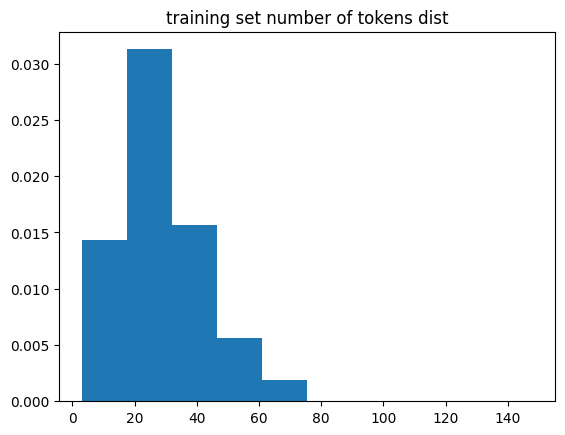

In [ ]:
# check text length dist in the trianing set
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name, tokens=None)


def count_tokens(data):
    return {"n_tokens": len(tokenizer.tokenize(data["sentence"]))}


# def count_tokens(ex):
#     ids = tokenizer(ex["text"], add_special_tokens=False)["input_ids"] # 疑问：add_special_tokens起什么作用？input_ids是什么
#     return {"n_tokens": len(ids)}

train_set_token_counts = train_set.map(count_tokens)["n_tokens"]

n_tokens_quantile = np.quantile(train_set_token_counts, 0.95)

plt.hist(train_set_token_counts, density=True)
plt.title("training set number of tokens dist")

print(f"training set number of tokens {0.95} quantile: {n_tokens_quantile}")

In [ ]:
def tokenize_func(data, max_length=tok_max_length):

    return tokenizer(
        data["sentence"], padding="max_length", truncation=True, max_length=max_length
    )


train_set_tokenized = train_set.map(tokenize_func, batched=True)
validation_set_tokenized = validation_set.map(tokenize_func, batched=True)
test_set_tokenized = test_set.map(tokenize_func, batched=True)


cols_to_be_dropped = ["input_ids", "attention_mask", "label"]

# train_set_tokenized = train_set_tokenized.remove_columns(
#     [c for c in train_set_tokenized.column_names if c not in cols_to_be_dropped]
# ).with_format("torch")

# validation_set_tokenized = validation_set_tokenized.remove_columns(
#     [c for c in validation_set_tokenized.column_names if c not in cols_to_be_dropped]
# ).with_format("torch")

# test_set_tokenized = test_set_tokenized.remove_columns(
#     [c for c in test_set_tokenized.column_names if c not in cols_to_be_dropped]
# ).with_format("torch")

train_set_tokenized

# tokenized results are in token_type_ids; attention_mask is to tell the model which tokens are real and which are padded results

Map:   0%|          | 0/3294 [00:00<?, ? examples/s]

Map:   0%|          | 0/582 [00:00<?, ? examples/s]

Map:   0%|          | 0/970 [00:00<?, ? examples/s]

Dataset({
    features: ['sentence', 'label', 'input_ids', 'attention_mask'],
    num_rows: 3294
})

## handle class imbalance

Text(0.5, 1.0, 'training set label dist')

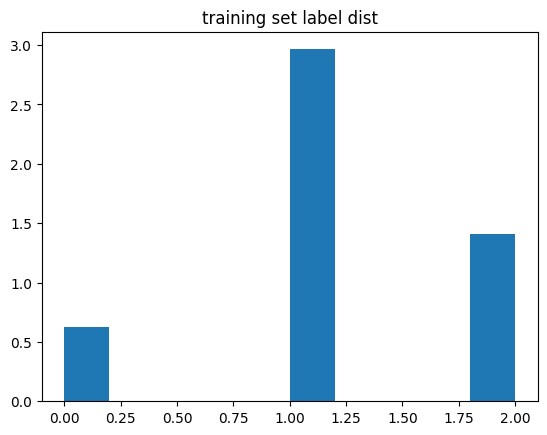

In [ ]:
plt.hist(train_set["label"], density=True)
plt.title("training set label dist")

In [ ]:
# reweight objective functions to handle imbalance

# customize loss funciton by assigning each class's weight inversely proportional to it's proportion
labels = train_set_tokenized["label"]
freq = collections.Counter(labels)
total = sum(freq.values())
class_weights = [total / freq[i] for i in range(len(freq))]
class_weights = torch.tensor(class_weights, dtype=torch.float, device=device)

## initialize model

In [ ]:
data_collator = transformers.DataCollatorWithPadding(
    tokenizer, pad_to_multiple_of=8 if torch.cuda.is_available() else None
)

acc = evaluate.load("accuracy")
f1 = evaluate.load("f1")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(-1)
    return {
        "accuracy": acc.compute(predictions=preds, references=labels)["accuracy"],
        "f1_macro": f1.compute(predictions=preds, references=labels, average="macro")[
            "f1"
        ],
    }

In [ ]:
class WeightedTrainer(
    transformers.Trainer
):  # inherent from transformers' Trainer class. only overwrite loss function
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss = F.cross_entropy(logits, labels, weight=class_weights)
        return (loss, outputs) if return_outputs else loss

## useful functions

In [ ]:
def train_or_load(
    trainer,
    output_dir,
    model_class=None,
    model_kwargs=None,
    skip_if_model_exists=True,
):
    """
    1) If a final model already exists in output_dir:
         - load model from output_dir
         - load trainer_state.json and restore log_history (for plotting)
    2) Otherwise:
         - train once
         - save model + tokenizer + state (including log_history)
    """
    if model_kwargs is None:
        model_kwargs = {}

    output_dir = pathlib.Path(output_dir)
    config_path = output_dir / "config.json"
    safetensors_path = output_dir / "model.safetensors"
    bin_path = output_dir / "pytorch_model.bin"
    state_path = output_dir / "trainer_state.json"

    # ---------- Check if a final model already exists ----------
    final_model_exists = config_path.exists() and (
        safetensors_path.exists() or bin_path.exists()
    )

    if skip_if_model_exists and final_model_exists:
        print(
            f"Found final model in '{output_dir}'. Loading model and skipping training."
        )

        # ---- load model weights ----
        if model_class is not None:
            model = model_class.from_pretrained(str(output_dir), **model_kwargs)

            if hasattr(trainer.args, "device") and hasattr(model, "to"):
                model.to(trainer.args.device)

            trainer.model = model
        else:
            print("No model_class provided. Using the existing trainer.model as-is.")

        # ---- load trainer_state.json so that log_history is available for plotting ----
        if state_path.exists():
            with state_path.open("r", encoding="utf-8") as f:
                state_dict = json.load(f)
            # HuggingFace saves "log_history" as a list of dicts
            if "log_history" in state_dict:
                trainer.state.log_history = state_dict["log_history"]
                print(f"Loaded log_history from '{state_path}'.")
            else:
                print(f"'log_history' not found in '{state_path}'.")
        else:
            print(
                f"No trainer_state.json found in '{output_dir}'. "
                "You will not be able to plot training curves for this run."
            )

        return trainer

    # ---------- Otherwise: train from scratch ----------
    print("No final model found. Starting training from scratch.")
    train_result = trainer.train()

    print(
        "Training finished. Saving final model + tokenizer + trainer state to output_dir."
    )

    # save model weights
    trainer.save_model(str(output_dir))

    # save tokenizer
    if getattr(trainer, "tokenizer", None) is not None:
        trainer.tokenizer.save_pretrained(str(output_dir))

    # save trainer state (includes log_history)
    trainer.save_state()

    # save metrics one more time
    metrics = train_result.metrics
    trainer.log_metrics("train", metrics)
    trainer.save_metrics("train", metrics)

    return trainer

In [ ]:
def plot_loss_and_confusion(trainer, eval_dataset, id2label):
    # ---- 1. Convert HuggingFace Trainer log_history to a pandas DataFrame ----
    # trainer.state.log_history is a list of dictionaries, where each dictionary
    # corresponds to either a training step log or an evaluation log.
    log_df = pd.DataFrame(trainer.state.log_history)

    # Training logs: rows that contain "loss" but do NOT contain "eval_loss".
    # These represent logs recorded during training steps.
    train_df = log_df[log_df["loss"].notna() & log_df["epoch"].notna()]

    # Evaluation logs: rows that contain "eval_loss".
    # These correspond to evaluation results at the end of an epoch.
    eval_df = log_df[log_df["eval_loss"].notna()]

    # Convert epoch numbers like 0.5, 1.0, 1.5, etc. to integers (1, 2, ...)
    # because evaluation logs usually represent epoch boundaries (e.g., epoch=1,2,...).
    train_epoch_idx = train_df["epoch"].round().astype(int)
    eval_epoch_idx = eval_df["epoch"].round().astype(int)

    # For each epoch, take the *last* logged training loss as its training loss.
    train_loss_by_epoch = train_df.groupby(train_epoch_idx)["loss"].last()

    # Extract validation loss / accuracy / F1 for each epoch.
    # These are directly provided by evaluation logs.
    eval_loss_by_epoch = eval_df.set_index(eval_epoch_idx)["eval_loss"]
    eval_acc_by_epoch = eval_df.set_index(eval_epoch_idx)["eval_accuracy"]
    eval_f1_by_epoch = eval_df.set_index(eval_epoch_idx)["eval_f1_macro"]

    # Sorted epoch list for plotting
    epochs = sorted(eval_loss_by_epoch.index.unique())

    # ---- 2. Create three subplots: loss / accuracy / macro F1 ----
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))

    # -------- Subplot 1: Training & Validation Loss --------
    ax = axes[0]
    ax.plot(
        train_loss_by_epoch.index,
        train_loss_by_epoch.values,
        marker="o",
        label="train_loss",
    )
    ax.plot(
        eval_loss_by_epoch.index,
        eval_loss_by_epoch.values,
        marker="o",
        label="val_loss",
    )
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.set_title("Training / Validation Loss")
    ax.grid(True, linestyle="--", alpha=0.4)
    ax.legend()

    # -------- Subplot 2: Validation Accuracy --------
    # Only evaluation logs contain accuracy, so only validation curve is plotted.
    ax = axes[1]
    ax.plot(
        eval_acc_by_epoch.index,
        eval_acc_by_epoch.values,
        marker="o",
        label="val_accuracy",
    )
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Accuracy")
    ax.set_title("Validation Accuracy")
    ax.grid(True, linestyle="--", alpha=0.4)
    ax.legend()

    # -------- Subplot 3: Validation Macro F1 --------
    ax = axes[2]
    ax.plot(
        eval_f1_by_epoch.index,
        eval_f1_by_epoch.values,
        marker="o",
        label="val_f1_macro",
    )
    ax.set_xlabel("Epoch")
    ax.set_ylabel("F1")
    ax.set_title("Validation F1 (Macro)")
    ax.grid(True, linestyle="--", alpha=0.4)
    ax.legend()

    plt.tight_layout()
    plt.show()

    # ---- 3. Compute and plot the confusion matrix on the validation set ----
    # Run prediction on the eval dataset
    preds_output = trainer.predict(eval_dataset)
    logits = preds_output.predictions
    y_true = preds_output.label_ids
    y_pred = np.argmax(logits, axis=-1)

    # Build confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred)
    labels = [id2label[i] for i in sorted(id2label.keys())]

    # Plot confusion matrix
    fig_cm, ax_cm = plt.subplots(figsize=(5, 5))
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", ax=ax_cm, values_format="d")
    ax_cm.set_title("Validation Confusion Matrix")
    plt.tight_layout()
    plt.show()

## ---actually fine-tuning---

### only classification head

In [ ]:
# initialize model
id2label = {0: "negative", 1: "neutral", 2: "positive"}
label2id = {v: k for k, v in id2label.items()}

model = transformers.AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=3, id2label=id2label, label2id=label2id
).to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
output_dir = f"{PATH}/output/finpb-{model_name}/only_classification_head"

train_args = transformers.TrainingArguments(
    output_dir=output_dir,
    overwrite_output_dir=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=50,
    learning_rate=2e-5,
    num_train_epochs=15,  # modified
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    weight_decay=0.01,
    lr_scheduler_type="linear",
    warmup_ratio=0.1,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    fp16=torch.cuda.is_available(),
    seed=seed,
    save_total_limit=3,
    report_to=[],
)

In [ ]:
trainer = WeightedTrainer(
    model=model,
    args=train_args,
    train_dataset=train_set_tokenized,
    eval_dataset=validation_set_tokenized,  # in the training log, performance metrics refers to evaluation set, not training set
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[
        transformers.EarlyStoppingCallback(
            early_stopping_patience=early_stopping_patience
        )
    ],  # after how many evaluations with no improvement to stop
)

In [ ]:
# Freeze all layers except for the classification head
for param in model.parameters():
    param.requires_grad = False

for param in model.classifier.parameters():
    param.requires_grad = True

print(
    f"number of trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}"
)

number of trainable parameters: 2307


In [ ]:
trainer = train_or_load(
    trainer=trainer,
    output_dir=output_dir,
    model_class=transformers.AutoModelForSequenceClassification,
    model_kwargs={
        # usually you do NOT need these, because config.json already saves num_labels, id2label etc.
        # but if you want to be explicit and consistent, you can keep them:
        "num_labels": 3,
        "id2label": id2label,
        "label2id": label2id,
    },
    skip_if_model_exists=True,  # True = if a final model exists, do NOT train again
)

Found final model in '/content/drive/MyDrive/ORIE 5160 Project/output/finpb-distilbert-base-uncased/only_classification_head'. Loading model and skipping training.
Loaded log_history from '/content/drive/MyDrive/ORIE 5160 Project/output/finpb-distilbert-base-uncased/only_classification_head/trainer_state.json'.


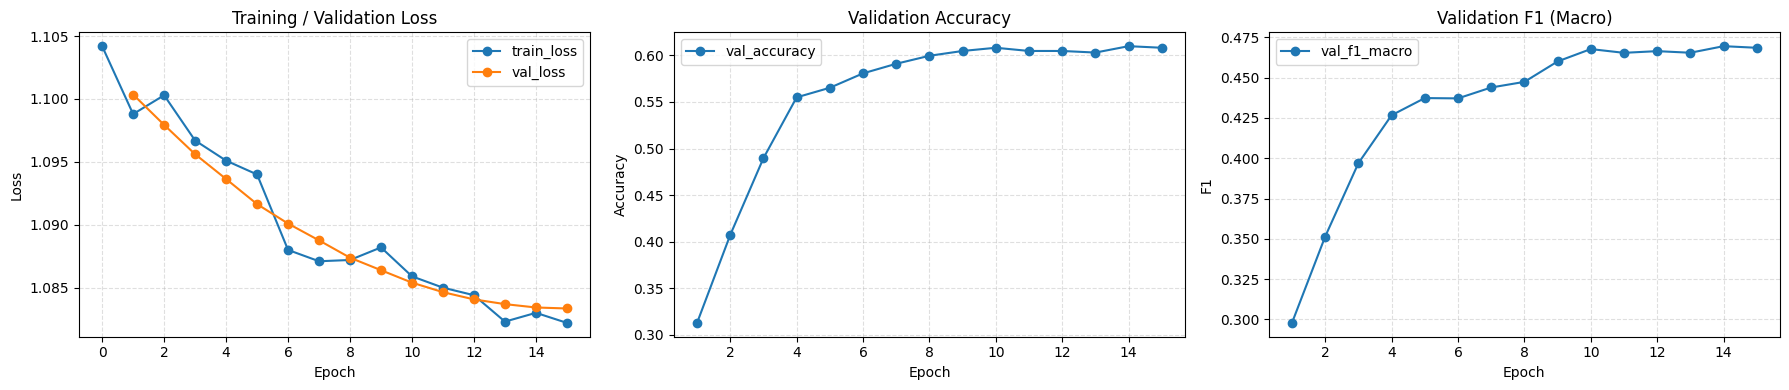

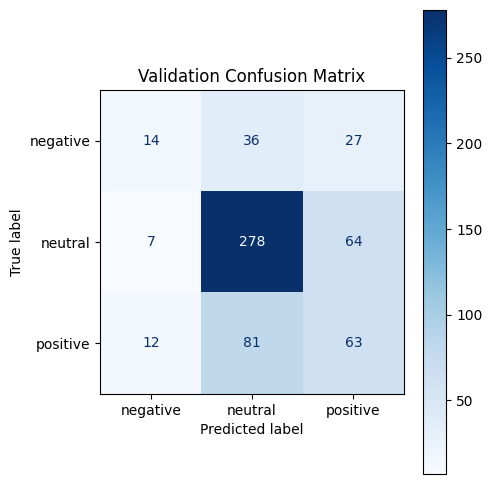

In [ ]:
plot_loss_and_confusion(trainer, validation_set_tokenized, id2label)

Test Accuracy: 0.591753
Test Macro F1: 0.471990


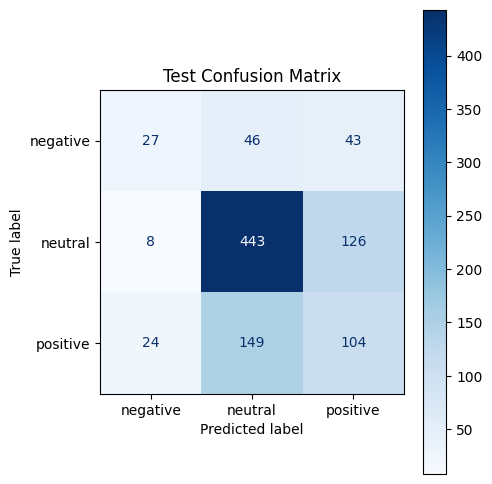

In [ ]:
preds_output = trainer.predict(test_set_tokenized)
logits = preds_output.predictions
y_true = preds_output.label_ids
y_pred = np.argmax(logits, axis=-1)

test_accuracy = metrics.accuracy_score(y_true, y_pred)
test_macro_f1 = metrics.f1_score(y_true, y_pred, average="macro")

print(f"Test Accuracy: {test_accuracy:.6f}")
print(f"Test Macro F1: {test_macro_f1:.6f}")

# Build confusion matrix
cm = metrics.confusion_matrix(y_true, y_pred)
labels = [id2label[i] for i in sorted(id2label.keys())]

# Plot confusion matrix
fig_cm, ax_cm = plt.subplots(figsize=(5, 5))
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="Blues", ax=ax_cm, values_format="d")
ax_cm.set_title("Test Confusion Matrix")
plt.tight_layout()
plt.show()

### 1-layer

In [ ]:
# initialize model
id2label = {0: "negative", 1: "neutral", 2: "positive"}
label2id = {v: k for k, v in id2label.items()}

model = transformers.AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=3, id2label=id2label, label2id=label2id
).to(device)

In [ ]:
output_dir = f"{PATH}/output/finpb-{model_name}/last_1_layer_and_classification_head"

train_args = transformers.TrainingArguments(
    output_dir=output_dir,
    overwrite_output_dir=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=50,
    learning_rate=2e-5,
    num_train_epochs=15,  # modified
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    weight_decay=0.01,
    lr_scheduler_type="linear",
    warmup_ratio=0.1,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    fp16=torch.cuda.is_available(),
    seed=seed,
    save_total_limit=3,
    report_to=[],
)

In [ ]:
trainer = WeightedTrainer(
    model=model,
    args=train_args,
    train_dataset=train_set_tokenized,
    eval_dataset=validation_set_tokenized,  # in the training log, performance metrics refers to evaluation set, not training set
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[
        transformers.EarlyStoppingCallback(
            early_stopping_patience=early_stopping_patience
        )
    ],  # after how many evaluations with no improvement to stop
)

In [ ]:
# Freeze all layers except for the classification head
for param in model.parameters():
    param.requires_grad = False

for param in model.classifier.parameters():
    param.requires_grad = True

# Unfreeze last Transformer block
for p in model.distilbert.transformer.layer[-1].parameters():
    p.requires_grad = True

print(
    f"number of trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}"
)

number of trainable parameters: 7090179


In [ ]:
trainer = train_or_load(
    trainer=trainer,
    output_dir=output_dir,
    model_class=transformers.AutoModelForSequenceClassification,
    model_kwargs={
        # usually you do NOT need these, because config.json already saves num_labels, id2label etc.
        # but if you want to be explicit and consistent, you can keep them:
        "num_labels": 3,
        "id2label": id2label,
        "label2id": label2id,
    },
    skip_if_model_exists=True,  # True = if a final model exists, do NOT train again
)

Found final model in '/content/drive/MyDrive/ORIE 5160 Project/output/finpb-distilbert-base-uncased/last_1_layer_and_classification_head'. Loading model and skipping training.
Loaded log_history from '/content/drive/MyDrive/ORIE 5160 Project/output/finpb-distilbert-base-uncased/last_1_layer_and_classification_head/trainer_state.json'.


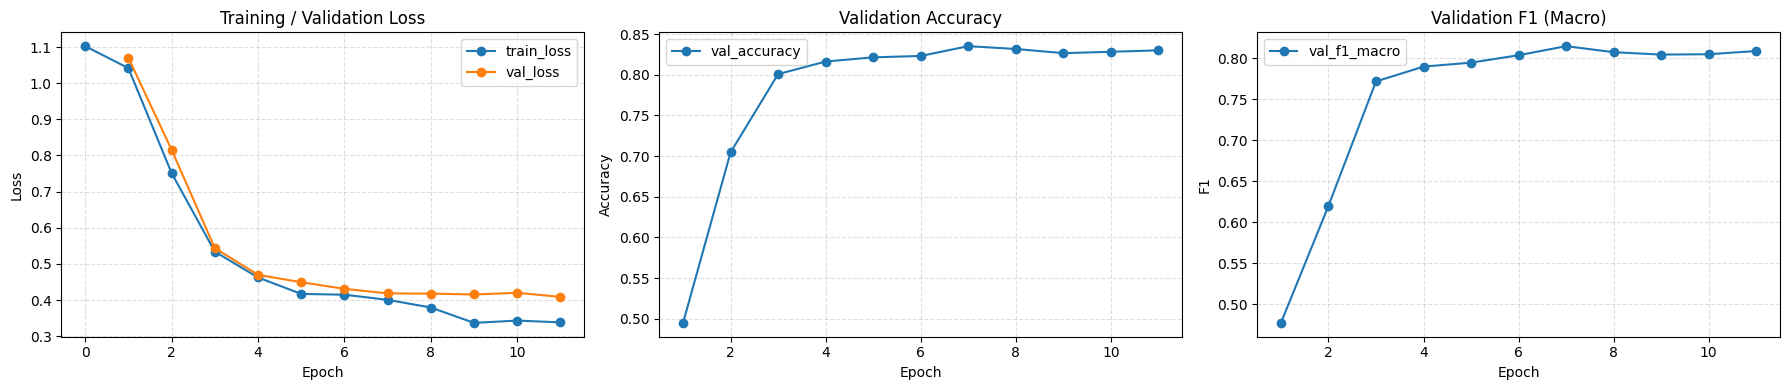

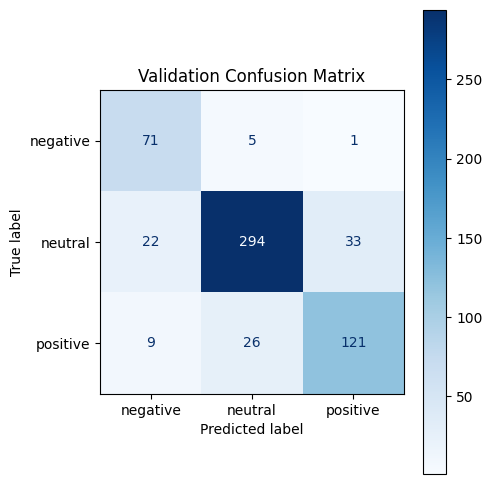

In [ ]:
plot_loss_and_confusion(trainer, validation_set_tokenized, id2label)

Test Accuracy: 0.811340
Test Macro F1: 0.783908


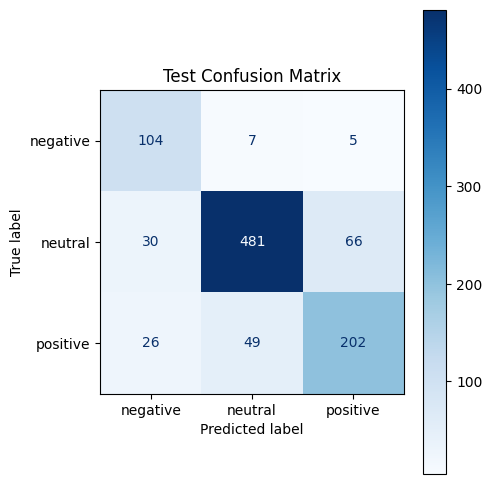

In [ ]:
preds_output = trainer.predict(test_set_tokenized)
logits = preds_output.predictions
y_true = preds_output.label_ids
y_pred = np.argmax(logits, axis=-1)

test_accuracy = metrics.accuracy_score(y_true, y_pred)
test_macro_f1 = metrics.f1_score(y_true, y_pred, average="macro")

print(f"Test Accuracy: {test_accuracy:.6f}")
print(f"Test Macro F1: {test_macro_f1:.6f}")

# Build confusion matrix
cm = metrics.confusion_matrix(y_true, y_pred)
labels = [id2label[i] for i in sorted(id2label.keys())]

# Plot confusion matrix
fig_cm, ax_cm = plt.subplots(figsize=(5, 5))
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="Blues", ax=ax_cm, values_format="d")
ax_cm.set_title("Test Confusion Matrix")
plt.tight_layout()
plt.show()

### 2-layers

In [ ]:
# initialize model
id2label = {0: "negative", 1: "neutral", 2: "positive"}
label2id = {v: k for k, v in id2label.items()}

model = transformers.AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=3, id2label=id2label, label2id=label2id
).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
output_dir = f"{PATH}/output/finpb-{model_name}/last_2_layers_and_classification_head"

train_args = transformers.TrainingArguments(
    output_dir=output_dir,
    overwrite_output_dir=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=50,
    learning_rate=2e-5,
    num_train_epochs=15,  # modified
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    weight_decay=0.01,
    lr_scheduler_type="linear",
    warmup_ratio=0.1,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    fp16=torch.cuda.is_available(),
    seed=seed,
    save_total_limit=3,
    report_to=[],
)

In [ ]:
trainer = WeightedTrainer(
    model=model,
    args=train_args,
    train_dataset=train_set_tokenized,
    eval_dataset=validation_set_tokenized,  # in the training log, performance metrics refers to evaluation set, not training set
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[
        transformers.EarlyStoppingCallback(
            early_stopping_patience=early_stopping_patience
        )
    ],  # after how many evaluations with no improvement to stop
)

In [ ]:
# Freeze all layers except for the classification head
for param in model.parameters():
    param.requires_grad = False

for param in model.classifier.parameters():
    param.requires_grad = True

# Unfreeze last Transformer block
for p in model.distilbert.transformer.layer[-1].parameters():
    p.requires_grad = True

# Unfreeze -2 Transformer block
for p in model.distilbert.transformer.layer[-2].parameters():
    p.requires_grad = True

print(
    f"number of trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}"
)

number of trainable parameters: 14178051


In [ ]:
trainer = train_or_load(
    trainer=trainer,
    output_dir=output_dir,
    model_class=transformers.AutoModelForSequenceClassification,
    model_kwargs={
        # usually you do NOT need these, because config.json already saves num_labels, id2label etc.
        # but if you want to be explicit and consistent, you can keep them:
        "num_labels": 3,
        "id2label": id2label,
        "label2id": label2id,
    },
    skip_if_model_exists=True,  # True = if a final model exists, do NOT train again
)

Found final model in '/content/drive/MyDrive/ORIE 5160 Project/output/finpb-distilbert-base-uncased/last_2_layers_and_classification_head'. Loading model and skipping training.
Loaded log_history from '/content/drive/MyDrive/ORIE 5160 Project/output/finpb-distilbert-base-uncased/last_2_layers_and_classification_head/trainer_state.json'.


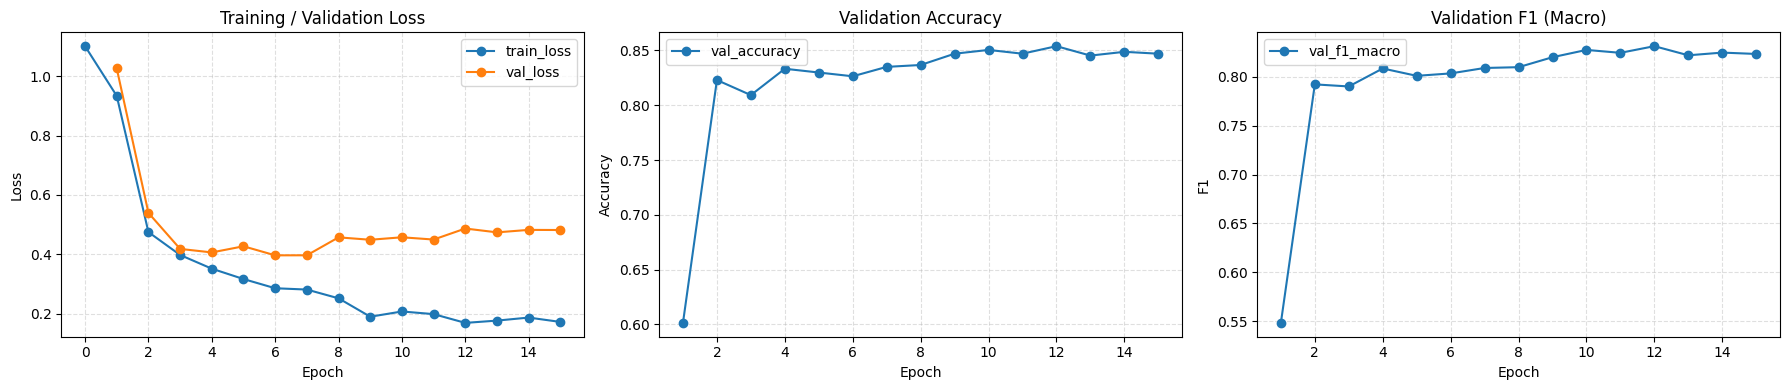

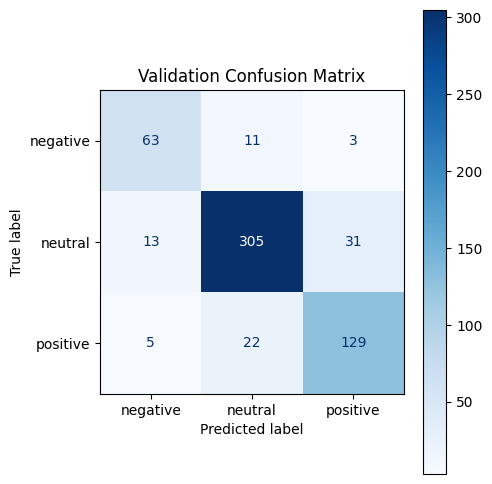

In [ ]:
plot_loss_and_confusion(trainer, validation_set_tokenized, id2label)

Test Accuracy: 0.830928
Test Macro F1: 0.805462


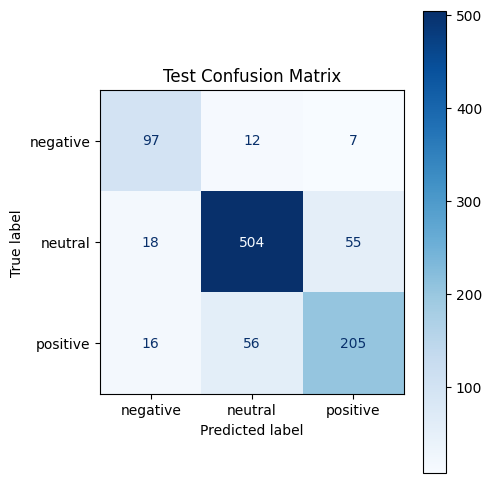

In [ ]:
preds_output = trainer.predict(test_set_tokenized)
logits = preds_output.predictions
y_true = preds_output.label_ids
y_pred = np.argmax(logits, axis=-1)

test_accuracy = metrics.accuracy_score(y_true, y_pred)
test_macro_f1 = metrics.f1_score(y_true, y_pred, average="macro")

print(f"Test Accuracy: {test_accuracy:.6f}")
print(f"Test Macro F1: {test_macro_f1:.6f}")

# Build confusion matrix
cm = metrics.confusion_matrix(y_true, y_pred)
labels = [id2label[i] for i in sorted(id2label.keys())]

# Plot confusion matrix
fig_cm, ax_cm = plt.subplots(figsize=(5, 5))
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="Blues", ax=ax_cm, values_format="d")
ax_cm.set_title("Test Confusion Matrix")
plt.tight_layout()
plt.show()

### 3-layers

In [ ]:
# initialize model
id2label = {0: "negative", 1: "neutral", 2: "positive"}
label2id = {v: k for k, v in id2label.items()}

model = transformers.AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=3, id2label=id2label, label2id=label2id
).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
output_dir = f"{PATH}/output/finpb-{model_name}/last_3_layers_and_classification_head"

train_args = transformers.TrainingArguments(
    output_dir=output_dir,
    overwrite_output_dir=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=50,
    learning_rate=2e-5,
    num_train_epochs=15,  # modified
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    weight_decay=0.01,
    lr_scheduler_type="linear",
    warmup_ratio=0.1,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    fp16=torch.cuda.is_available(),
    seed=seed,
    save_total_limit=3,
    report_to=[],
)

In [ ]:
trainer = WeightedTrainer(
    model=model,
    args=train_args,
    train_dataset=train_set_tokenized,
    eval_dataset=validation_set_tokenized,  # in the training log, performance metrics refers to evaluation set, not training set
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[
        transformers.EarlyStoppingCallback(
            early_stopping_patience=early_stopping_patience
        )
    ],  # after how many evaluations with no improvement to stop
)

In [ ]:
# Freeze all layers except for the classification head
for param in model.parameters():
    param.requires_grad = False

for param in model.classifier.parameters():
    param.requires_grad = True

# Unfreeze last Transformer block
for p in model.distilbert.transformer.layer[-1].parameters():
    p.requires_grad = True

# Unfreeze -2 Transformer block
for p in model.distilbert.transformer.layer[-2].parameters():
    p.requires_grad = True

# Unfreeze -3 Transformer block
for p in model.distilbert.transformer.layer[-3].parameters():
    p.requires_grad = True

print(
    f"number of trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}"
)

number of trainable parameters: 21265923


In [ ]:
trainer = train_or_load(
    trainer=trainer,
    output_dir=output_dir,
    model_class=transformers.AutoModelForSequenceClassification,
    model_kwargs={
        # usually you do NOT need these, because config.json already saves num_labels, id2label etc.
        # but if you want to be explicit and consistent, you can keep them:
        "num_labels": 3,
        "id2label": id2label,
        "label2id": label2id,
    },
    skip_if_model_exists=True,  # True = if a final model exists, do NOT train again
)

Found final model in '/content/drive/MyDrive/ORIE 5160 Project/output/finpb-distilbert-base-uncased/last_2_layers_and_classification_head'. Loading model and skipping training.
Loaded log_history from '/content/drive/MyDrive/ORIE 5160 Project/output/finpb-distilbert-base-uncased/last_2_layers_and_classification_head/trainer_state.json'.


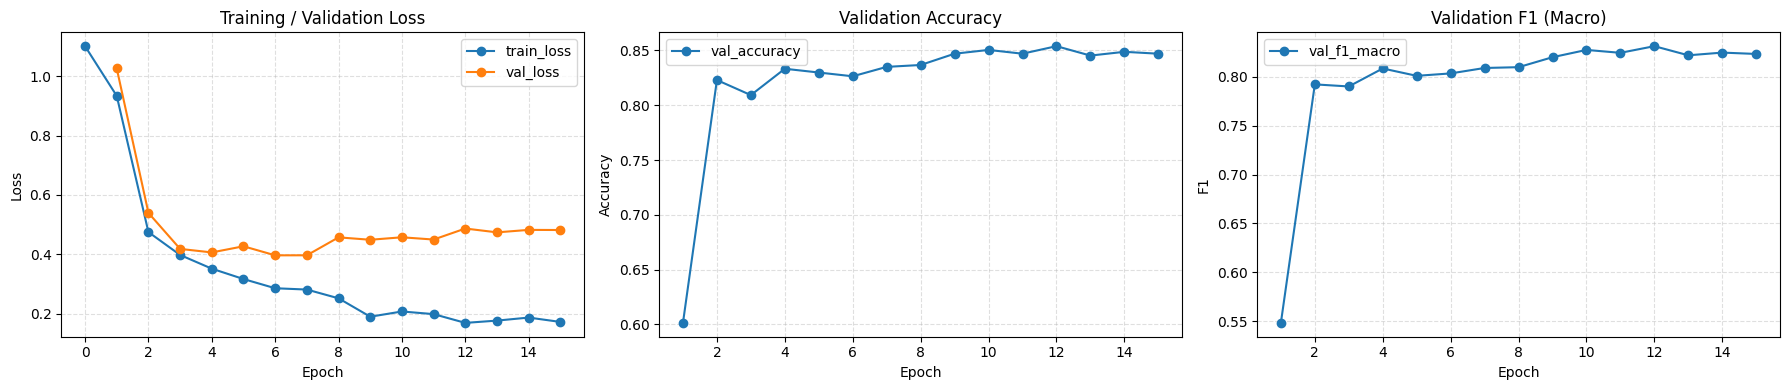

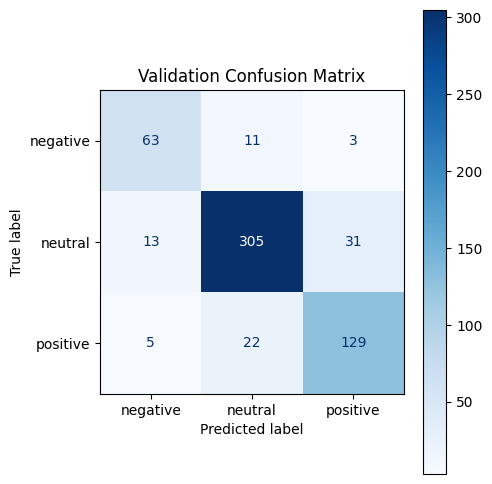

In [ ]:
plot_loss_and_confusion(trainer, validation_set_tokenized, id2label)

Test Accuracy: 0.830928
Test Macro F1: 0.805462


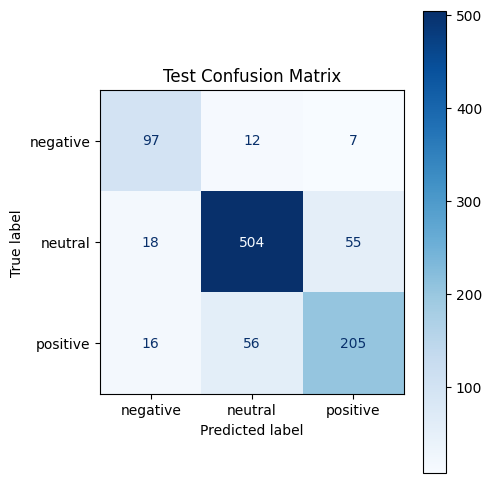

In [ ]:
preds_output = trainer.predict(test_set_tokenized)
logits = preds_output.predictions
y_true = preds_output.label_ids
y_pred = np.argmax(logits, axis=-1)

test_accuracy = metrics.accuracy_score(y_true, y_pred)
test_macro_f1 = metrics.f1_score(y_true, y_pred, average="macro")

print(f"Test Accuracy: {test_accuracy:.6f}")
print(f"Test Macro F1: {test_macro_f1:.6f}")

# Build confusion matrix
cm = metrics.confusion_matrix(y_true, y_pred)
labels = [id2label[i] for i in sorted(id2label.keys())]

# Plot confusion matrix
fig_cm, ax_cm = plt.subplots(figsize=(5, 5))
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="Blues", ax=ax_cm, values_format="d")
ax_cm.set_title("Test Confusion Matrix")
plt.tight_layout()
plt.show()

### full

In [ ]:
# initialize model
id2label = {0: "negative", 1: "neutral", 2: "positive"}
label2id = {v: k for k, v in id2label.items()}

model = transformers.AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=3, id2label=id2label, label2id=label2id
).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
output_dir = f"{PATH}/output/finpb-{model_name}/full_parameters_tuning"

train_args = transformers.TrainingArguments(
    output_dir=output_dir,
    overwrite_output_dir=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=50,
    learning_rate=2e-5,
    num_train_epochs=15,  # modified
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    weight_decay=0.01,
    lr_scheduler_type="linear",
    warmup_ratio=0.1,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    fp16=torch.cuda.is_available(),
    seed=seed,
    save_total_limit=3,
    report_to=[],
)

In [ ]:
trainer = WeightedTrainer(
    model=model,
    args=train_args,
    train_dataset=train_set_tokenized,
    eval_dataset=validation_set_tokenized,  # in the training log, performance metrics refers to evaluation set, not training set
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[
        transformers.EarlyStoppingCallback(
            early_stopping_patience=early_stopping_patience
        )
    ],  # after how many evaluations with no improvement to stop
)

In [ ]:
# Unfreeze all the parameters
for param in model.parameters():
    param.requires_grad = True

print(
    f"number of trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}"
)

number of trainable parameters: 66955779


In [ ]:
trainer = train_or_load(
    trainer=trainer,
    output_dir=output_dir,
    model_class=transformers.AutoModelForSequenceClassification,
    model_kwargs={
        # usually you do NOT need these, because config.json already saves num_labels, id2label etc.
        # but if you want to be explicit and consistent, you can keep them:
        "num_labels": 3,
        "id2label": id2label,
        "label2id": label2id,
    },
    skip_if_model_exists=True,  # True = if a final model exists, do NOT train again
)

Found final model in '/content/drive/MyDrive/ORIE 5160 Project/output/finpb-distilbert-base-uncased/full_parameters_tuning'. Loading model and skipping training.
Loaded log_history from '/content/drive/MyDrive/ORIE 5160 Project/output/finpb-distilbert-base-uncased/full_parameters_tuning/trainer_state.json'.


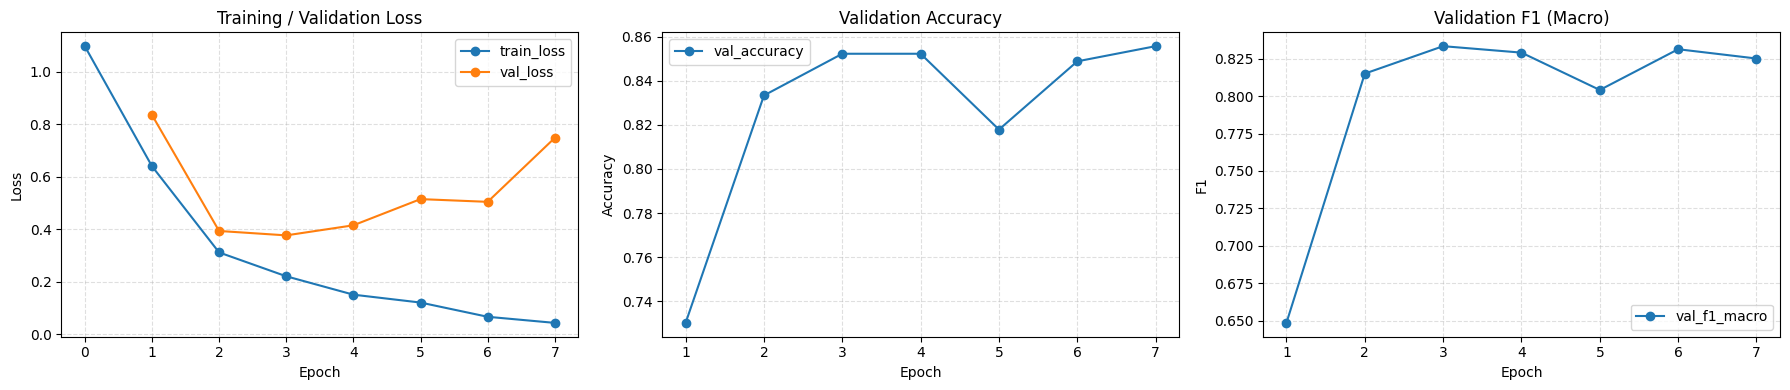

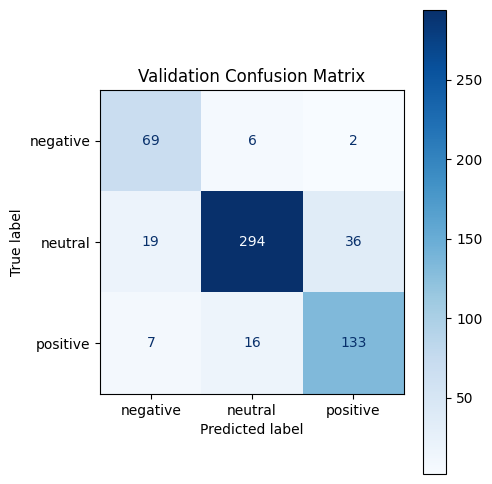

In [ ]:
plot_loss_and_confusion(trainer, validation_set_tokenized, id2label)

Test Accuracy: 0.820619
Test Macro F1: 0.796658


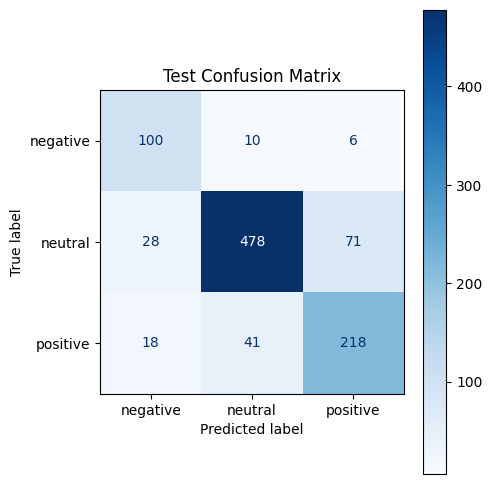

In [ ]:
preds_output = trainer.predict(test_set_tokenized)
logits = preds_output.predictions
y_true = preds_output.label_ids
y_pred = np.argmax(logits, axis=-1)

test_accuracy = metrics.accuracy_score(y_true, y_pred)
test_macro_f1 = metrics.f1_score(y_true, y_pred, average="macro")

print(f"Test Accuracy: {test_accuracy:.6f}")
print(f"Test Macro F1: {test_macro_f1:.6f}")

# Build confusion matrix
cm = metrics.confusion_matrix(y_true, y_pred)
labels = [id2label[i] for i in sorted(id2label.keys())]

# Plot confusion matrix
fig_cm, ax_cm = plt.subplots(figsize=(5, 5))
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="Blues", ax=ax_cm, values_format="d")
ax_cm.set_title("Test Confusion Matrix")
plt.tight_layout()
plt.show()

### LoRA

In [ ]:
# initialize model
id2label = {0: "negative", 1: "neutral", 2: "positive"}
label2id = {v: k for k, v in id2label.items()}

model = transformers.AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=3, id2label=id2label, label2id=label2id
).to(device)

lora_config = peft.LoraConfig(
    task_type="SEQ_CLS",
    target_modules=["q_lin", "k_lin", "v_lin", "out_lin"],
    r=8,
    lora_alpha=16,
    lora_dropout=0.05,
)
model = peft.get_peft_model(model, lora_config)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
output_dir = f"{PATH}/output/finpb-{model_name}/lora"

train_args = transformers.TrainingArguments(
    output_dir=output_dir,
    overwrite_output_dir=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=50,
    learning_rate=2e-5,
    num_train_epochs=15,  # modified
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    weight_decay=0.01,
    lr_scheduler_type="linear",
    warmup_ratio=0.1,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    fp16=torch.cuda.is_available(),
    seed=seed,
    save_total_limit=3,
    report_to=[],
)

In [ ]:
trainer = WeightedTrainer(
    model=model,
    args=train_args,
    train_dataset=train_set_tokenized,
    eval_dataset=validation_set_tokenized,  # in the training log, performance metrics refers to evaluation set, not training set
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[
        transformers.EarlyStoppingCallback(
            early_stopping_patience=early_stopping_patience
        )
    ],  # after how many evaluations with no improvement to stop
)

In [ ]:
print(
    f"number of trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}"
)

number of trainable parameters: 887811


In [ ]:
trainer = train_or_load(
    trainer=trainer,
    output_dir=output_dir,
    model_class=transformers.AutoModelForSequenceClassification,
    model_kwargs={
        # usually you do NOT need these, because config.json already saves num_labels, id2label etc.
        # but if you want to be explicit and consistent, you can keep them:
        "num_labels": 3,
        "id2label": id2label,
        "label2id": label2id,
    },
    skip_if_model_exists=True,  # True = if a final model exists, do NOT train again
)

No final model found. Starting training from scratch.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,1.086500,1.078557,0.493127,0.453793
2,1.017900,0.965307,0.646048,0.548033
3,0.772600,0.657349,0.754296,0.716698
4,0.578500,0.552415,0.778351,0.752639
5,0.502700,0.538530,0.780069,0.752642
6,0.484400,0.512082,0.774914,0.754999
7,0.459100,0.489261,0.797251,0.770649
8,0.454000,0.480755,0.795533,0.773595
9,0.444400,0.477344,0.804124,0.775567
10,0.427600,0.480735,0.810997,0.784392


Training finished. Saving final model + tokenizer + trainer state to output_dir.


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


***** train metrics *****
  epoch                    =       15.0
  total_flos               =   777664GF
  train_loss               =     0.5626
  train_runtime            = 0:01:17.16
  train_samples_per_second =     640.31
  train_steps_per_second   =     20.022


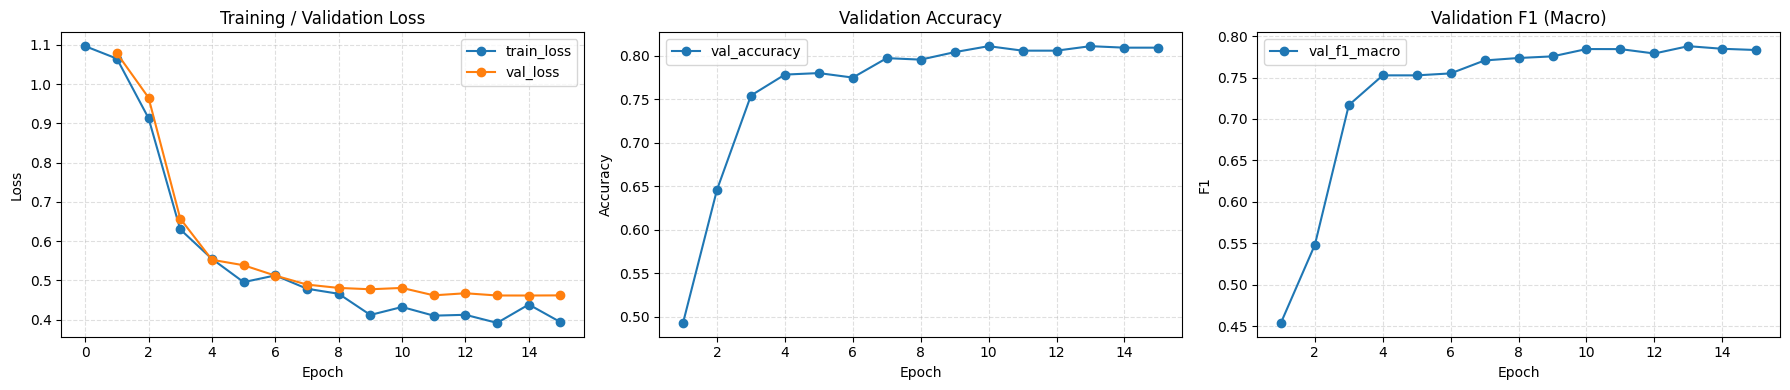

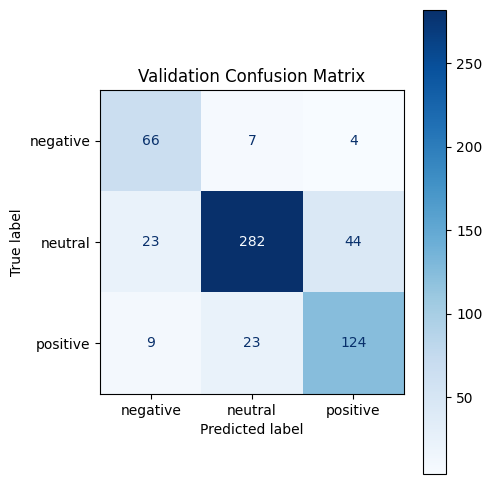

In [ ]:
plot_loss_and_confusion(trainer, validation_set_tokenized, id2label)

Test Accuracy: 0.781443
Test Macro F1: 0.760074


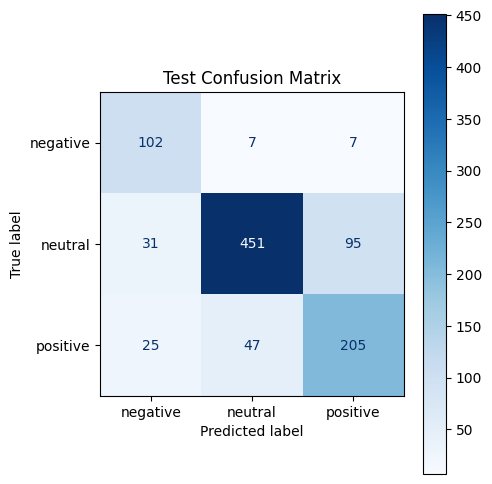

In [ ]:
preds_output = trainer.predict(test_set_tokenized)
logits = preds_output.predictions
y_true = preds_output.label_ids
y_pred = np.argmax(logits, axis=-1)

test_accuracy = metrics.accuracy_score(y_true, y_pred)
test_macro_f1 = metrics.f1_score(y_true, y_pred, average="macro")

print(f"Test Accuracy: {test_accuracy:.6f}")
print(f"Test Macro F1: {test_macro_f1:.6f}")

# Build confusion matrix
cm = metrics.confusion_matrix(y_true, y_pred)
labels = [id2label[i] for i in sorted(id2label.keys())]

# Plot confusion matrix
fig_cm, ax_cm = plt.subplots(figsize=(5, 5))
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="Blues", ax=ax_cm, values_format="d")
ax_cm.set_title("Test Confusion Matrix")
plt.tight_layout()
plt.show()

### BitFit

In [ ]:
# initialize model
id2label = {0: "negative", 1: "neutral", 2: "positive"}
label2id = {v: k for k, v in id2label.items()}

model = transformers.AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=3, id2label=id2label, label2id=label2id,
).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
output_dir = f"{PATH}/output/finpb-{model_name}/bitfit"

train_args = transformers.TrainingArguments(
    output_dir=output_dir,
    overwrite_output_dir=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=50,
    learning_rate=2e-5,
    num_train_epochs=15,  # modified
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    weight_decay=0.01,
    lr_scheduler_type="linear",
    warmup_ratio=0.1,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    fp16=torch.cuda.is_available(),
    seed=seed,
    save_total_limit=3,
    report_to=[],
)

In [ ]:
trainer = WeightedTrainer(
    model=model,
    args=train_args,
    train_dataset=train_set_tokenized,
    eval_dataset=validation_set_tokenized,  # in the training log, performance metrics refers to evaluation set, not training set
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[
        transformers.EarlyStoppingCallback(
            early_stopping_patience=early_stopping_patience
        )
    ],  # after how many evaluations with no improvement to stop
)

In [ ]:
# Freeze all layers except for the classification head
for param in model.parameters():
    param.requires_grad = False

for param in model.classifier.parameters():
    param.requires_grad = True

# Unfreeze all bias terms for bitfit
for name, param in model.named_parameters():
    if "bias" in name.lower():
        param.requires_grad = True

# Also unfreeze LayerNorms + pre_classifier + classifier head
for name, param in model.named_parameters():
    if (
        "LayerNorm" in name
        or "layer_norm" in name
        or "pre_classifier" in name
        or "classifier" in name
    ):
        param.requires_grad = True

print(
    f"number of trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}"
)

number of trainable parameters: 654339


In [ ]:
trainer = train_or_load(
    trainer=trainer,
    output_dir=output_dir,
    model_class=transformers.AutoModelForSequenceClassification,
    model_kwargs={
        # usually you do NOT need these, because config.json already saves num_labels, id2label etc.
        # but if you want to be explicit and consistent, you can keep them:
        "num_labels": 3,
        "id2label": id2label,
        "label2id": label2id,
    },
    skip_if_model_exists=True,  # True = if a final model exists, do NOT train again
)

No final model found. Starting training from scratch.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,1.091100,1.081443,0.458763,0.428369
2,1.041100,1.006148,0.647766,0.554840
3,0.936800,0.883499,0.697595,0.608543
4,0.836300,0.764611,0.728522,0.664061
5,0.712000,0.663305,0.749141,0.714541
6,0.647200,0.597710,0.761168,0.740666
7,0.595200,0.562158,0.771478,0.743560
8,0.564800,0.538493,0.774914,0.751257
9,0.553600,0.527215,0.774914,0.745634
10,0.537200,0.525071,0.771478,0.743403


Training finished. Saving final model + tokenizer + trainer state to output_dir.


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


***** train metrics *****
  epoch                    =       12.0
  total_flos               =   609581GF
  train_loss               =     0.7229
  train_runtime            = 0:00:52.83
  train_samples_per_second =    935.192
  train_steps_per_second   =     29.242


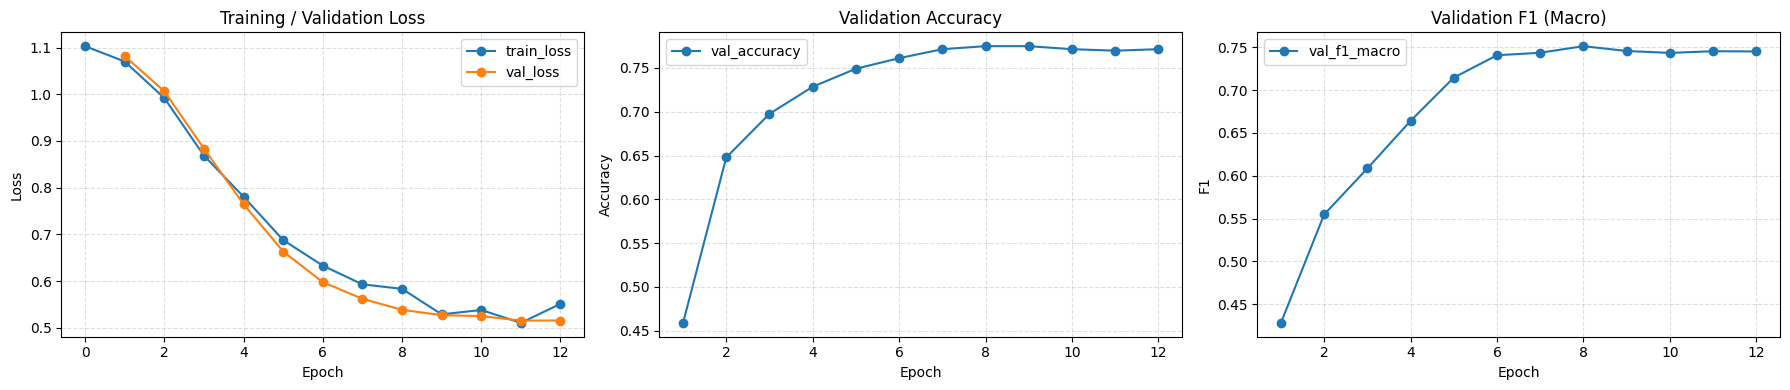

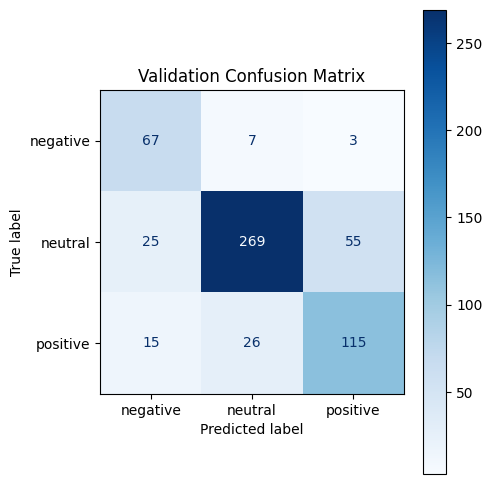

In [ ]:
plot_loss_and_confusion(trainer, validation_set_tokenized, id2label)

Test Accuracy: 0.726804
Test Macro F1: 0.697314


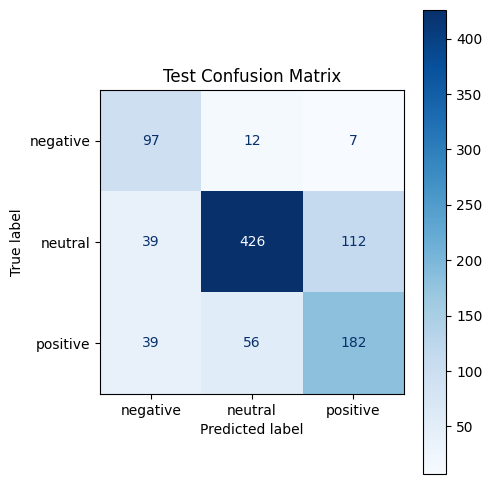

In [ ]:
preds_output = trainer.predict(test_set_tokenized)
logits = preds_output.predictions
y_true = preds_output.label_ids
y_pred = np.argmax(logits, axis=-1)

test_accuracy = metrics.accuracy_score(y_true, y_pred)
test_macro_f1 = metrics.f1_score(y_true, y_pred, average="macro")

print(f"Test Accuracy: {test_accuracy:.6f}")
print(f"Test Macro F1: {test_macro_f1:.6f}")

# Build confusion matrix
cm = metrics.confusion_matrix(y_true, y_pred)
labels = [id2label[i] for i in sorted(id2label.keys())]

# Plot confusion matrix
fig_cm, ax_cm = plt.subplots(figsize=(5, 5))
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="Blues", ax=ax_cm, values_format="d")
ax_cm.set_title("Test Confusion Matrix")
plt.tight_layout()
plt.show()